### Basemodel

In this notebook I take the data from the Happiness Index for a first basic model. I will try out different algorithms to decide which one performs best for the data. 

Target:
+ life_ladder  

Features:
+ log_gdp_per_capita


import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import happy_functions as haf

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error 

read the data:

In [2]:
df = pd.read_csv("data/life_ladder_2005_2022_gdp_social.txt", delimiter=',')
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.lower()

a short look into the content:

In [3]:
df.head(5)

,country_name,year,life_ladder,log_gdp_per_capita,social_support
0,Afghanistan,2008,3.724,7.350,0.451
1,Afghanistan,2009,4.402,7.509,0.552
2,Afghanistan,2010,4.758,7.614,0.539
3,Afghanistan,2011,3.832,7.581,0.521
4,Afghanistan,2012,3.783,7.661,0.521


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country_name        2166 non-null   object 
 1   year                2166 non-null   int64  
 2   life_ladder         2166 non-null   float64
 3   log_gdp_per_capita  2166 non-null   float64
 4   social_support      2166 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 84.7+ KB


The data has already been cleansed. I can use it directly.  
  
Define Feature (X) and Target (y):

In [5]:
X = df[['log_gdp_per_capita']]
y = df['life_ladder']

In [6]:
print(X.shape, y.shape)

(2166, 1) (2166,)


Train-Test-Split:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1516, 1) (650, 1) (1516,) (650,)


Now I am testing which results different algorithms produce. 
The metric that is considered for the performance of the particular model is the mean absolute error (MAE).  

### Linear Regression
The first algorithm I want to test is linear regression. I will test this with different polynomials as parameters.   
At the end I will compare the MAE of the particular models for the train and the test data in a graph

In [8]:
lin_reg_error_lst = []
for i in range(1,11):
    polynomial_features = PolynomialFeatures(degree=i, include_bias=False)
    x_poly_train = polynomial_features.fit_transform(X_train)
    x_poly_test = polynomial_features.transform(X_test)

    lin_reg_poly = haf.train_model(LinearRegression, x_poly_train, y_train)

    lin_reg_error_lst.append({'model_name': 'linreg_poly_' + str(i),  
                      'train_mae': mean_absolute_error(y_train, lin_reg_poly.predict(x_poly_train)).round(3), 
                      'test_mae': mean_absolute_error(y_test, lin_reg_poly.predict(x_poly_test)).round(3)})

lin_reg_error_df = pd.DataFrame(lin_reg_error_lst)
lin_reg_error_df['delta_MAE'] = abs(lin_reg_error_df['train_mae'] - lin_reg_error_df['test_mae'])
lin_reg_error_df.sort_values(by = ['delta_MAE', 'test_mae'])

,model_name,train_mae,test_mae,delta_MAE
7,linreg_poly_8,0.519,0.520,0.001
4,linreg_poly_5,0.529,0.530,0.001
6,linreg_poly_7,0.523,0.521,0.002
8,linreg_poly_9,0.519,0.515,0.004
0,linreg_poly_1,0.559,0.554,0.005
9,linreg_poly_10,0.520,0.512,0.008
5,linreg_poly_6,0.523,0.514,0.009
3,linreg_poly_4,0.546,0.537,0.009
1,linreg_poly_2,0.547,0.536,0.011
2,linreg_poly_3,0.547,0.536,0.011


graphical comparison (MAE)

/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


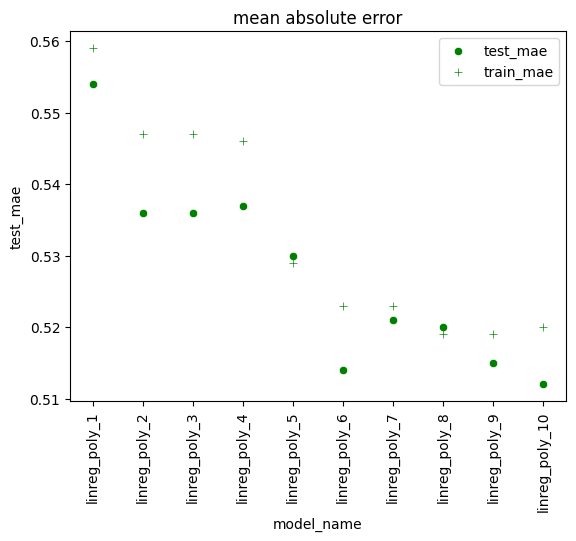

In [9]:
haf.scatter_mae_train_test_data(lin_reg_error_df)

The lowest MAEs are achieved on the degree 6 and the degree 10 model. But the delta between the mae_test and the mae_train is very high. So I also look at the points with lower delta. That is the case for degree 5, 7 and 8 model.   
Nevertheless, I am not thrilled because the MAE for the training data is worse than the MAE for the test data. My expectation is that it is the other way round. 
But luckily there are other algorithms to test. I will continue with that. 
For now though, I collect the metrics with the lowest delta in a new dataframe and compare them with the results from the other models at the end of the notebook.   

In [10]:
part_lin_reg = lin_reg_error_df.sort_values(by =['delta_MAE', 'test_mae']).iloc[:6]
part_lin_reg

,model_name,train_mae,test_mae,delta_MAE
7,linreg_poly_8,0.519,0.520,0.001
4,linreg_poly_5,0.529,0.530,0.001
6,linreg_poly_7,0.523,0.521,0.002
8,linreg_poly_9,0.519,0.515,0.004
0,linreg_poly_1,0.559,0.554,0.005
9,linreg_poly_10,0.520,0.512,0.008


### KNN

I the next step I will test the K-Nearest Neighbors Algorithm the same way.   
As parameter I will use a variable number of neighbors and variable distance metrics

In [11]:
knn_error_lst = []
for metr in range(1,4):
    for neigh in np.arange(5,55,5): 
        knn = haf.train_model(KNeighborsRegressor, X_train, y_train,n_neighbors=neigh, p=metr, weights='uniform' )
     
        knn_error_lst.append({'model_name': 'knn_' + str(metr) + '_' + str(neigh),  
                      'train_mae': mean_absolute_error(y_train, knn.predict(X_train)).round(3), 
                      'test_mae': mean_absolute_error(y_test, knn.predict(X_test)).round(3)})
        
knn_error_df = pd.DataFrame(knn_error_lst)
knn_error_df['delta_MAE'] = abs(knn_error_df['train_mae'] - knn_error_df['test_mae'])
knn_error_df.sort_values(by = ['delta_MAE', 'test_mae']).head(7)

,model_name,train_mae,test_mae,delta_MAE
8,knn_1_45,0.504,0.506,0.002
9,knn_1_50,0.504,0.506,0.002
18,knn_2_45,0.504,0.506,0.002
19,knn_2_50,0.504,0.506,0.002
28,knn_3_45,0.504,0.506,0.002
29,knn_3_50,0.504,0.506,0.002
7,knn_1_40,0.503,0.506,0.003


/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


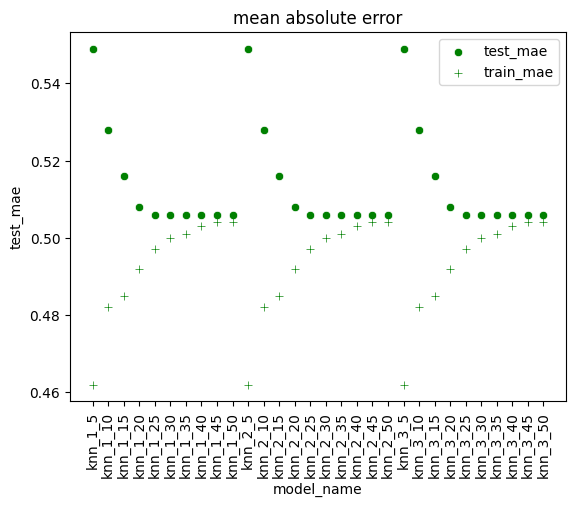

In [12]:
haf.scatter_mae_train_test_data(knn_error_df)

Interesting. Around the area of lower number of neighbours I have good results for the training data, but the results of the test data are very far away. Both are approaching each other with a larger number of neighbours. 
You can also see that the different distance metrics don't make a big difference. It would be sufficient to choose the simplest one. 

That's why we're doing it again now, but only with a metric.   
(Due to the flow in the notebook, I will do this in a new area instead of overwriting the previous loop)

In [13]:
knn_error_lst = []
for metr in range(1,2):
    for neigh in np.arange(10,55,5): 
        knn = haf.train_model(KNeighborsRegressor, X_train, y_train,n_neighbors=neigh, p=metr, weights='uniform' )
     
        knn_error_lst.append({'model_name': 'knn_' + str(metr) + '_' + str(neigh),  
                      'train_mae': mean_absolute_error(y_train, knn.predict(X_train)).round(3), 
                      'test_mae': mean_absolute_error(y_test, knn.predict(X_test)).round(3)})
        
knn_error_df = pd.DataFrame(knn_error_lst)
knn_error_df['delta_MAE'] = abs(knn_error_df['train_mae'] - knn_error_df['test_mae'])
knn_error_df.sort_values(by = ['delta_MAE', 'test_mae'])

,model_name,train_mae,test_mae,delta_MAE
7,knn_1_45,0.504,0.506,0.002
8,knn_1_50,0.504,0.506,0.002
6,knn_1_40,0.503,0.506,0.003
5,knn_1_35,0.501,0.506,0.005
4,knn_1_30,0.500,0.506,0.006
3,knn_1_25,0.497,0.506,0.009
2,knn_1_20,0.492,0.508,0.016
1,knn_1_15,0.485,0.516,0.031
0,knn_1_10,0.482,0.528,0.046


/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


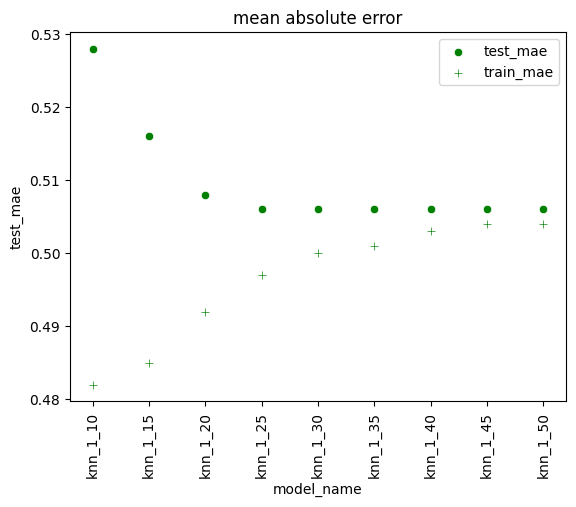

In [14]:
haf.scatter_mae_train_test_data(knn_error_df)

I like the results for the KNN Algorithm much better. I will take all of these 9 values with for the comparison:

In [15]:
part_knn = knn_error_df.sort_values(by = ['delta_MAE', 'test_mae']).iloc[:9]
part_knn

,model_name,train_mae,test_mae,delta_MAE
7,knn_1_45,0.504,0.506,0.002
8,knn_1_50,0.504,0.506,0.002
6,knn_1_40,0.503,0.506,0.003
5,knn_1_35,0.501,0.506,0.005
4,knn_1_30,0.500,0.506,0.006
3,knn_1_25,0.497,0.506,0.009
2,knn_1_20,0.492,0.508,0.016
1,knn_1_15,0.485,0.516,0.031
0,knn_1_10,0.482,0.528,0.046


### Decision Tree

The next Algorithm I want to test is the Decision Tree.   
To limit the growth of the tree I will use the maximum depth of the tree and the maximum leaf node as parameter.

In [16]:
dectree_error_lst = []
for depth in np.arange(4,7,1):
    for leaf in np.arange(10,51,2): 
        dectree = haf.train_model(DecisionTreeRegressor, X_train, y_train,
                            max_depth = depth, 
                            max_leaf_nodes = leaf,
                            splitter = 'best')

        dectree_error_lst.append({'model_name': 'dectree_dep_' + str(depth) + '_max_leaf_' + str(leaf),  
                      'train_mae': mean_absolute_error(y_train, dectree.predict(X_train)).round(3), 
                      'test_mae': mean_absolute_error(y_test, dectree.predict(X_test)).round(3)})
        
dectree_error_df = pd.DataFrame(dectree_error_lst)
dectree_error_df['delta_MAE'] = abs(dectree_error_df['train_mae'] - dectree_error_df['test_mae'])
dectree_error_df.sort_values(by = ['delta_MAE', 'test_mae'])

,model_name,train_mae,test_mae,delta_MAE
0,dectree_dep_4_max_leaf_10,0.503,0.522,0.019
21,dectree_dep_5_max_leaf_10,0.503,0.522,0.019
42,dectree_dep_6_max_leaf_10,0.503,0.522,0.019
23,dectree_dep_5_max_leaf_14,0.501,0.521,0.020
22,dectree_dep_5_max_leaf_12,0.503,0.523,0.020
...,...,...,...,...
56,dectree_dep_6_max_leaf_38,0.483,0.525,0.042
59,dectree_dep_6_max_leaf_44,0.481,0.524,0.043
60,dectree_dep_6_max_leaf_46,0.480,0.524,0.044
61,dectree_dep_6_max_leaf_48,0.480,0.524,0.044


/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


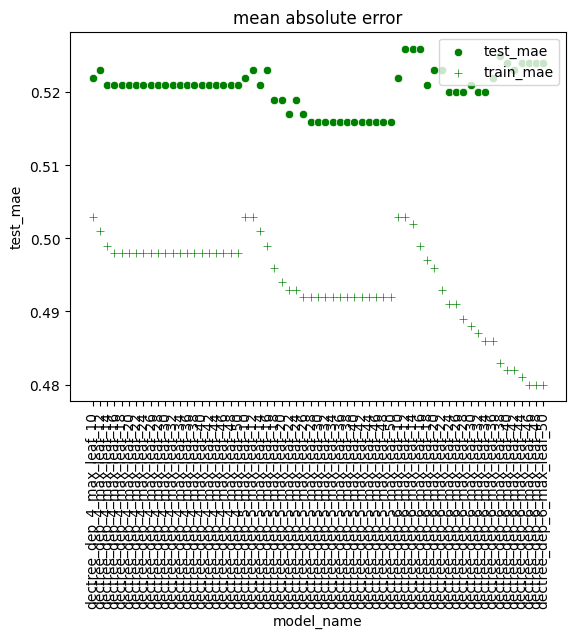

In [17]:
haf.scatter_mae_train_test_data(dectree_error_df)

You can see that for the maximum depths 4 and 5, the tree creation runs into a limit.
Nevertheless, the range with depth 5 is interesting, because this is the range with the lowest MAE for the test data. I will take a closer look at this area (again in the following section)  
However, I will also separate out the area that no longer changes.

In [26]:
dectree_error_lst = []
for depth in np.arange(5,6,1):
    for leaf in np.arange(10,31,2): 
        dectree = haf.train_model(DecisionTreeRegressor, X_train, y_train,
                            max_depth = depth, 
                            max_leaf_nodes = leaf,
                            splitter = 'best')

        dectree_error_lst.append({'model_name': 'dectree_dep_' + str(depth) + '_max_leaf_' + str(leaf),  
                      'train_mae': mean_absolute_error(y_train, dectree.predict(X_train)).round(3), 
                      'test_mae': mean_absolute_error(y_test, dectree.predict(X_test)).round(3)})
        
dectree_error_df = pd.DataFrame(dectree_error_lst)
dectree_error_df['delta_MAE'] = abs(dectree_error_df['train_mae'] - dectree_error_df['test_mae'])
dectree_error_df.sort_values(by = ['delta_MAE', 'test_mae'])

,model_name,train_mae,test_mae,delta_MAE
0,dectree_dep_5_max_leaf_10,0.503,0.522,0.019
2,dectree_dep_5_max_leaf_14,0.501,0.521,0.020
1,dectree_dep_5_max_leaf_12,0.503,0.523,0.020
4,dectree_dep_5_max_leaf_18,0.496,0.519,0.023
9,dectree_dep_5_max_leaf_28,0.492,0.516,0.024
10,dectree_dep_5_max_leaf_30,0.492,0.516,0.024
6,dectree_dep_5_max_leaf_22,0.493,0.517,0.024
3,dectree_dep_5_max_leaf_16,0.499,0.523,0.024
8,dectree_dep_5_max_leaf_26,0.492,0.517,0.025
5,dectree_dep_5_max_leaf_20,0.494,0.519,0.025


/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


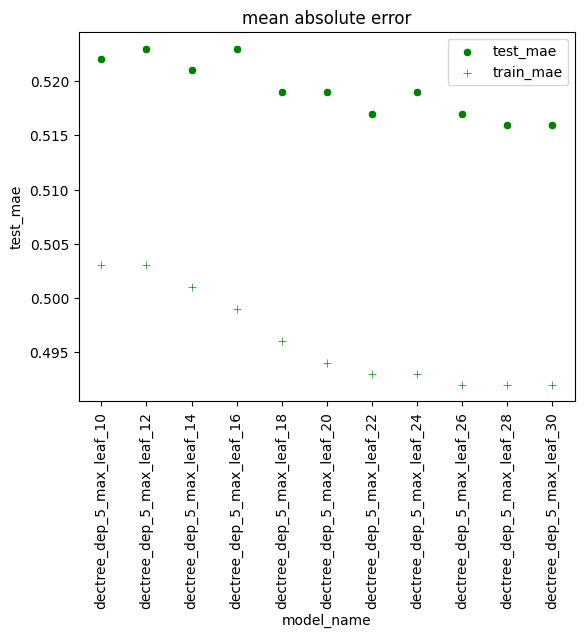

In [27]:
haf.scatter_mae_train_test_data(dectree_error_df)

For the comparison at the end, I again take the results with the smallest possible difference between train and test data. However, values from this range with low MAE should also be included. If I sort by delta, the first 6 entries cover this range.

In [28]:
part_dec_tree = dectree_error_df.sort_values(by = ['delta_MAE', 'test_mae']).iloc[:6]
part_dec_tree

,model_name,train_mae,test_mae,delta_MAE
0,dectree_dep_5_max_leaf_10,0.503,0.522,0.019
2,dectree_dep_5_max_leaf_14,0.501,0.521,0.020
1,dectree_dep_5_max_leaf_12,0.503,0.523,0.020
4,dectree_dep_5_max_leaf_18,0.496,0.519,0.023
9,dectree_dep_5_max_leaf_28,0.492,0.516,0.024
10,dectree_dep_5_max_leaf_30,0.492,0.516,0.024


### Random Forest

The last algorithm I test is the Random Forest.   
Here, too, I limit the maximum depth of the tree and the maximum leaf node.  If I decide to use this algorithm later, I could also try out other parameters to optimise the result.

Since Random Forest is much more computationally complex, I start with a coarser parameter selection than with the others to get an overview first, then I will take a closer look at interesting areas.

In [ ]:
random_trees_error_lst = []
for tree_depth in np.arange(3,11,1):
    for tree_leaf in np.arange(5,55,10): 
        random_forest = haf.train_model(RandomForestRegressor, X_train, y_train,
                            n_estimators=100, 
                            random_state=123, 
                            max_depth = tree_depth,
                            max_leaf_nodes = tree_leaf,
                            max_features = 'sqrt',
                            n_jobs=-1, verbose = 1)
        
        n_nodes = []
        maximum_depths = []
        for tree_idx in random_forest.estimators_:
            n_nodes.append(tree_idx.tree_.node_count)
            maximum_depths.append(tree_idx.tree_.max_depth)
        
        mean_node_num = int(np.mean(n_nodes))

        random_trees_error_lst.append({'model_name': 'forest_tree_depth' + str(tree_depth) + '_max_leaf_' + str(tree_leaf),  
                      'train_mae': mean_absolute_error(y_train, random_forest.predict(X_train)).round(3), 
                      'test_mae': mean_absolute_error(y_test, random_forest.predict(X_test)).round(3),
                      'mean_node_num': mean_node_num})
        
random_trees_error_df = pd.DataFrame(random_trees_error_lst)
random_trees_error_df['delta_MAE'] = abs(random_trees_error_df['train_mae'] - random_trees_error_df['test_mae'])
random_trees_error_df.sort_values(by = ['delta_MAE', 'test_mae']).head(10)

/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


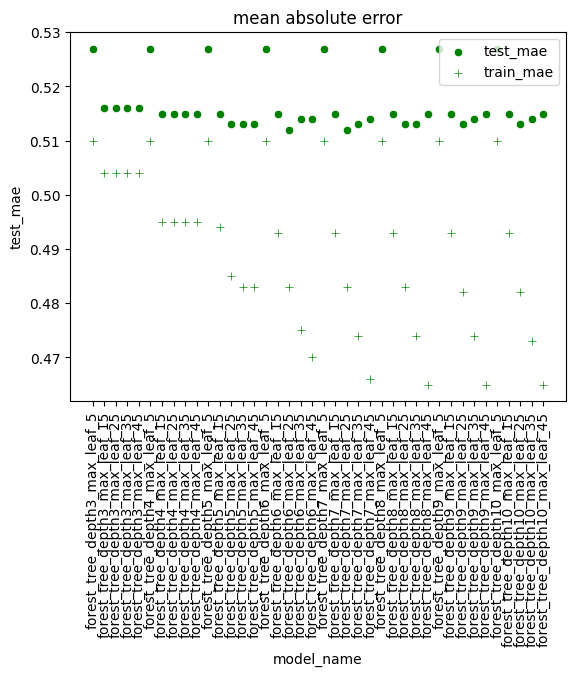

In [34]:
haf.scatter_mae_train_test_data(random_trees_error_df)

The interesting areas here are with the max depth 5, 6 and 7, where the MAE for the test data are the lowest.  
let's have a closer look:

In [ ]:
random_trees_error_lst = []
for tree_depth in np.arange(5,7,1):
    for tree_leaf in np.arange(5,55,5): 
        random_forest = haf.train_model(RandomForestRegressor, X_train, y_train,
                            n_estimators=100, 
                            random_state=123, 
                            max_depth = tree_depth,
                            max_leaf_nodes = tree_leaf,
                            max_features = 'sqrt',
                            n_jobs=-1, verbose = 1)
        
        n_nodes = []
        maximum_depths = []
        for tree_idx in random_forest.estimators_:
            n_nodes.append(tree_idx.tree_.node_count)
            maximum_depths.append(tree_idx.tree_.max_depth)
        
        mean_node_num = int(np.mean(n_nodes))

        random_trees_error_lst.append({'model_name': 'forest_tree_depth' + str(tree_depth) + '_max_leaf_' + str(tree_leaf),  
                      'train_mae': mean_absolute_error(y_train, random_forest.predict(X_train)).round(3), 
                      'test_mae': mean_absolute_error(y_test, random_forest.predict(X_test)).round(3),
                      'mean_node_num': mean_node_num})
        
random_trees_error_df = pd.DataFrame(random_trees_error_lst)
random_trees_error_df['delta_MAE'] = abs(random_trees_error_df['train_mae'] - random_trees_error_df['test_mae'])
random_trees_error_df.sort_values(by = ['delta_MAE', 'test_mae']).head(10)

/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


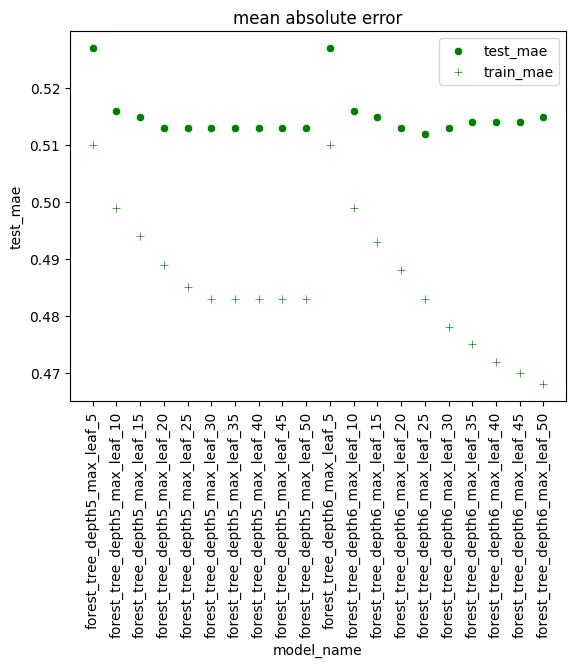

In [40]:
haf.scatter_mae_train_test_data(random_trees_error_df)

I took max depth 7 out again, there were no big differences between the values (for the areas with low delta)  
And then I collect the values with the lowest delta in this range again. 

In [42]:
part_forest = random_trees_error_df.sort_values(by = ['delta_MAE', 'test_mae']).iloc[:8]
part_forest

,model_name,train_mae,test_mae,mean_node_num,delta_MAE
1,forest_tree_depth5_max_leaf_10,0.499,0.516,19,0.017
11,forest_tree_depth6_max_leaf_10,0.499,0.516,19,0.017
0,forest_tree_depth5_max_leaf_5,0.510,0.527,9,0.017
10,forest_tree_depth6_max_leaf_5,0.510,0.527,9,0.017
2,forest_tree_depth5_max_leaf_15,0.494,0.515,29,0.021
12,forest_tree_depth6_max_leaf_15,0.493,0.515,29,0.022
3,forest_tree_depth5_max_leaf_20,0.489,0.513,39,0.024
13,forest_tree_depth6_max_leaf_20,0.488,0.513,39,0.025


### Comparison of performance of the models

In [43]:
error_df = pd.concat([part_lin_reg, 
                      part_knn,
                      part_dec_tree,
                      part_forest],  axis = 0)
                      
error_df.sort_values(by = ['delta_MAE', 'test_mae'])

,model_name,train_mae,test_mae,delta_MAE,mean_node_num
7,linreg_poly_8,0.519,0.520,0.001,NaN
4,linreg_poly_5,0.529,0.530,0.001,NaN
7,knn_1_45,0.504,0.506,0.002,NaN
8,knn_1_50,0.504,0.506,0.002,NaN
6,linreg_poly_7,0.523,0.521,0.002,NaN
6,knn_1_40,0.503,0.506,0.003,NaN
8,linreg_poly_9,0.519,0.515,0.004,NaN
5,knn_1_35,0.501,0.506,0.005,NaN
0,linreg_poly_1,0.559,0.554,0.005,NaN
4,knn_1_30,0.500,0.506,0.006,NaN


/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


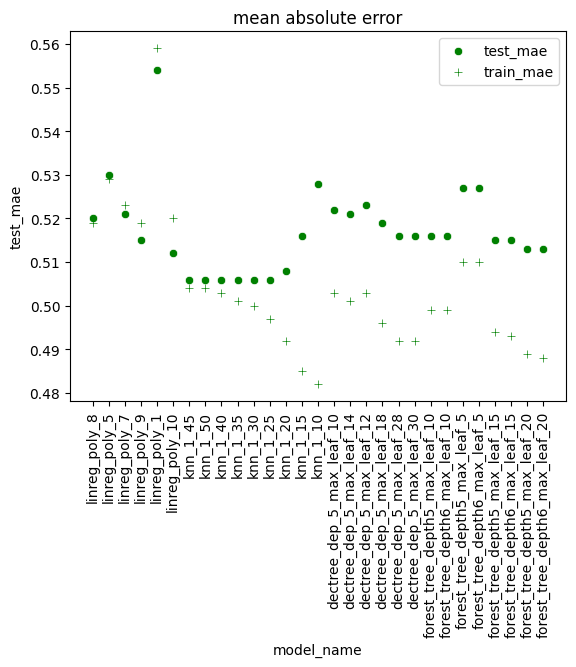

In [44]:
haf.scatter_mae_train_test_data(error_df)

The comparison of the different models shows the best performance for the KNN algorithm. This allows the test data to be predicted with the lowest error.   
I will therefore decide for the KNN algorithm for the basic model. 